In [1]:
%matplotlib inline
from matplotlib.colors import LogNorm, SymLogNorm
import numpy as np
import glob
import scipy
from astropy.io import fits
import matplotlib.pyplot as plt

from ctisim import ITL_AMP_GEOM
from ctisim.fitting import FullSimulatedModel, OverscanFitting

In [2]:
infile = '/nfs/slac/g/ki/ki19/lsst/snyder18/LSST/Data/BOT/6790D_linearity/R20/S02/R20_S02_overscan_results.fits'

hdulist = fits.open(infile)
max_signal = 160000.
read_noise = 7.2

amp = 7
start = 1
stop = 15

## Model params
ctiexp = np.log10(1.1E-6)
drift_scale = 0.0002
decay_time = 2.5
trapsize1 = 3.8
scaling = 0.08
trapsize2 = 38.0
f0 = 17700.
k = 0.001
emission_time = 0.4
params0 = (ctiexp, drift_scale, decay_time, trapsize1, scaling, trapsize2, f0, k, emission_time)

## Constraints
constraints = [(np.log10(8.E-7), np.log10(3.E-6)),
               (0.00015, 0.00025),
               (2.3, 2.6),
               (0.0, 5.0),
               (0.05, 0.1),
               (35.0, 45.0),
               (16000., 18000.),
               (0.0007, 0.0013),
               (0.35, 0.5)]

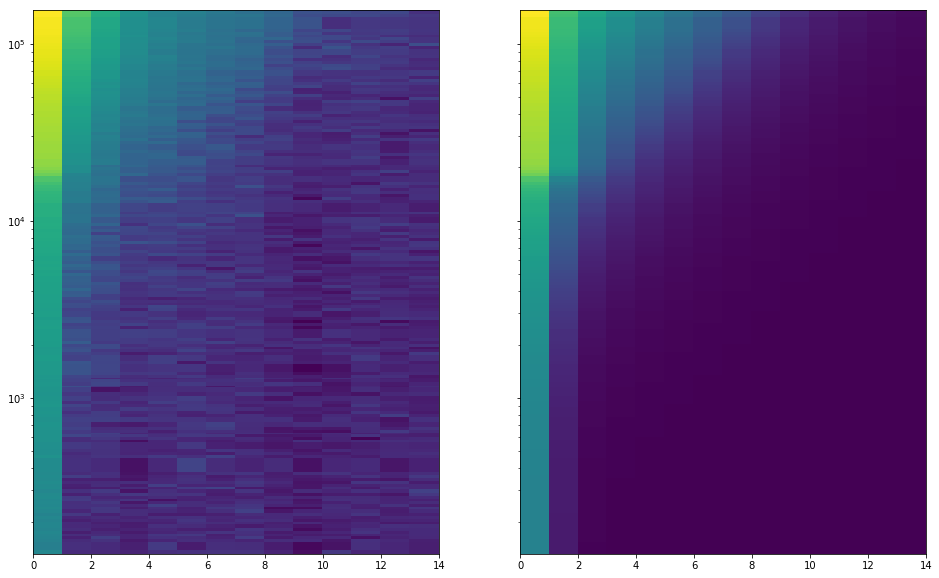

In [3]:
## Signals
all_signals = hdulist[amp].data['FLATFIELD_SIGNAL']
signals = all_signals[all_signals<max_signal]

## Data
data = hdulist[amp].data['COLUMN_MEAN'][all_signals<max_signal, start:stop+1]

## Model
fitting_model = FullSimulatedModel(params0, ITL_AMP_GEOM)
model = fitting_model.results(signals, start=start, stop=stop)

y=signals
x=np.arange(model.shape[1])
X,Y=np.meshgrid(x, y)

fig, axes = plt.subplots(1, 2, figsize=(16, 10), sharey=True)

im0 = axes[0].pcolor(X,Y,data, norm=SymLogNorm(1.0))
im1 = axes[1].pcolor(X,Y,model, norm=SymLogNorm(1.0))
axes[0].set_yscale('log')
axes[1].set_yscale('log')

In [13]:
fit_task = OverscanFitting(params0, constraints, FullSimulatedModel, start=start, stop=stop)

error = 7.2/np.sqrt(2000.)
fit_task.rms_error(params0, signals, data, read_noise/np.sqrt(2000.), ITL_AMP_GEOM)

2.8612484294548786

In [17]:
res = scipy.optimize.minimize(fit_task.rms_error,
                            params0,
                            args=(signals, data, read_noise/np.sqrt(2000.), ITL_AMP_GEOM),
                            bounds=constraints, method='SLSQP')

params_new = res.x


## Testing Electronic Effect Correction

In [2]:
from ctisim import SegmentSimulator, FloatingOutputAmplifier, ITL_AMP_GEOM
from ctisim.matrix import electronics_operator, cti_inverse_operator, trap_operator
from ctisim import LogisticTrap, LinearTrap, SplineTrap
from ctisim.core import SerialTrap
import scipy.interpolate as interp

trap0 = LinearTrap(4.0, 0.4, 1, 0.08)
trap1 = LogisticTrap(40.0, 0.4, 1, 17500, 0.001)
traps = [trap0, trap1]

In [7]:
cti = 1.E-6
scale = 0.0002
decay_time = 2.4
output_amplifier = FloatingOutputAmplifier(1.0, scale, decay_time)

start = ITL_AMP_GEOM.nx+ITL_AMP_GEOM.prescan_width
stop = start+21

signals = np.logspace(1, np.log10(175000.), 200)
imarr = np.zeros((signals.shape[0], ITL_AMP_GEOM.nx))

## Simulate ramp readout
ramp = SegmentSimulator(imarr, ITL_AMP_GEOM.prescan_width, output_amplifier, cti=cti, traps=traps)
ramp.ramp_exp(signals)
model_results = ramp.readout(serial_overscan_width=ITL_AMP_GEOM.serial_overscan_width,
                             parallel_overscan_width=0)

print(model_results.shape)

(200, 576)


/nfs/slac/g/ki/ki19/lsst/snyder18/software/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:138: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)
/nfs/slac/g/ki/ki19/lsst/snyder18/software/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:208: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)


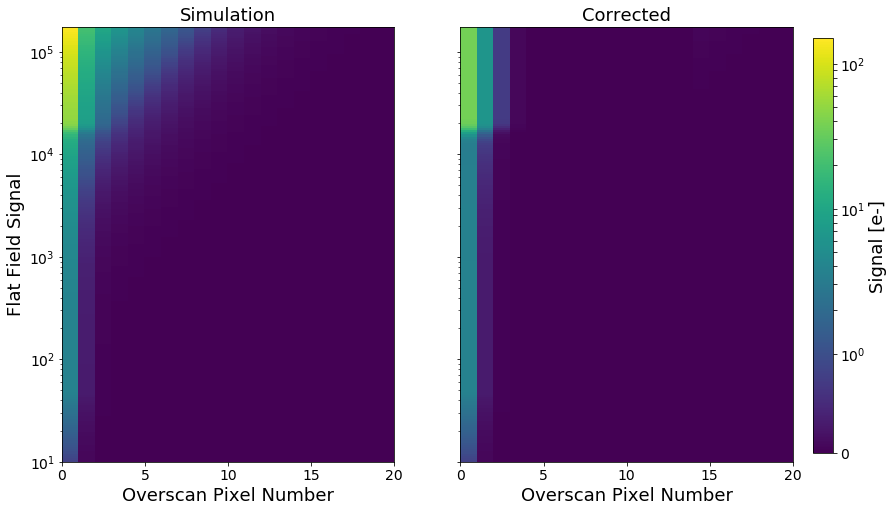

In [20]:
E = electronics_operator(model_results, scale, decay_time, num_previous_pixels=15)
Dinv = cti_inverse_operator(cti, model_results.shape[1])

original = model_results[:, start:stop]

corrected = (model_results-E)
for j in range(corrected.shape[0]):
    corrected[j, :] = Dinv*corrected[j, :]
    
corrected = corrected[:, start:stop]
    
vmin = 0.0
vmax = np.max(original)

y=signals
x=np.arange(original.shape[1])
X,Y=np.meshgrid(x, y)

fig, axes = plt.subplots(1, 2, figsize=(14, 8), sharey=True)
im0 = axes[0].pcolor(X, Y, original, 
                     norm=SymLogNorm(1.0), vmin=vmin, vmax=vmax)
im1 = axes[1].pcolor(X, Y, corrected, 
                     norm=SymLogNorm(1.0), vmin=vmin, vmax=vmax)
axes[0].set_yscale('log')
axes[0].set_ylabel('Flat Field Signal', fontsize=18)
axes[0].set_xlabel('Overscan Pixel Number', fontsize=18)
axes[0].tick_params(axis='both', which='major', labelsize=14)
axes[0].set_title('Simulation', fontsize=18)
axes[1].tick_params(axis='both', which='major', labelsize=14)
axes[1].set_xlabel('Overscan Pixel Number', fontsize=18)
axes[1].set_title('Corrected', fontsize=18)
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.14, 0.02, 0.72])
cbar= fig.colorbar(im0, cax=cbar_ax)
cbar.set_label('Signal [e-]', fontsize=18)
cbar.ax.tick_params(labelsize=14) 

In [21]:
class SplineTrap(SerialTrap):

    parameter_keywords = None
    model_type = 'spline'

    def __init__(self, interpolant, emission_time, pixel):

        super().__init__(200000., emission_time, pixel)
        self.f = interpolant

## Need to pad
y = np.sum(corrected, axis=1)
x = signals

# Pad left with ramp
y = np.pad(y, (10, 0), 'linear_ramp', end_values=(0, 0))
x = np.pad(x, (10, 0), 'linear_ramp', end_values=(0, 0))

# Pad right with constant
y = np.pad(y, (1, 1), 'constant', constant_values=(0, np.max(y)))
x = np.pad(x, (1, 1), 'constant', constant_values=(-1, 200000.))

f = interp.interp1d(x, y)

spltrap = SplineTrap(f, 0.4, 1)

/nfs/slac/g/ki/ki19/lsst/snyder18/software/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:138: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)
/nfs/slac/g/ki/ki19/lsst/snyder18/software/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:208: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)


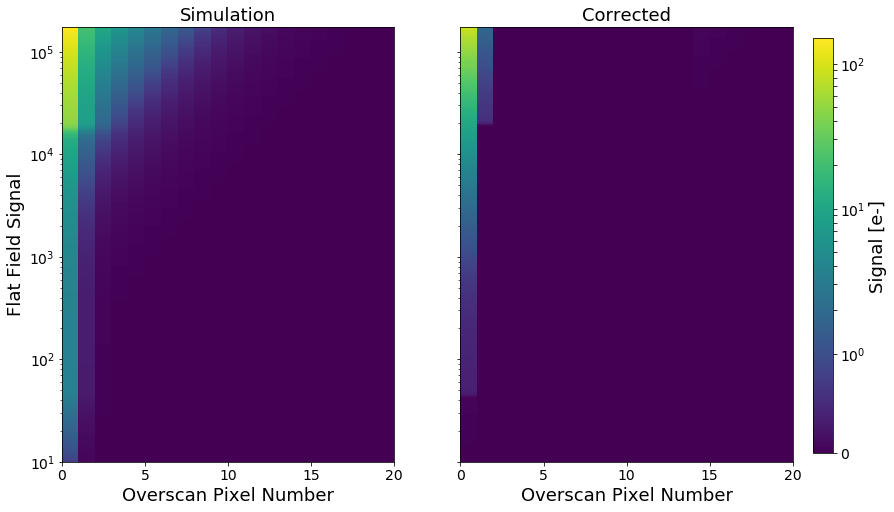

In [28]:
E = electronics_operator(model_results, scale, decay_time, num_previous_pixels=15)
Dinv = cti_inverse_operator(cti, model_results.shape[1])
#T = trap_operator(model_results, *traps, tau=0.4)
T = trap_operator(model_results, spltrap, tau=0.4)

original = model_results[:, start:stop]

new_corrected = (model_results-E)
new_corrected = (new_corrected-(1.-cti)*T)
    
new_corrected = new_corrected[:, start:stop]
    
vmin = 0.0
vmax = np.max(original)

y=signals
x=np.arange(original.shape[1])
X,Y=np.meshgrid(x, y)

fig, axes = plt.subplots(1, 2, figsize=(14, 8), sharey=True)
im0 = axes[0].pcolor(X, Y, original, 
                     norm=SymLogNorm(1.0), vmin=vmin, vmax=vmax)
im1 = axes[1].pcolor(X, Y, new_corrected, 
                     norm=SymLogNorm(1.0), vmin=vmin, vmax=vmax)
axes[0].set_yscale('log')
axes[0].set_ylabel('Flat Field Signal', fontsize=18)
axes[0].set_xlabel('Overscan Pixel Number', fontsize=18)
axes[0].tick_params(axis='both', which='major', labelsize=14)
axes[0].set_title('Simulation', fontsize=18)
axes[1].tick_params(axis='both', which='major', labelsize=14)
axes[1].set_xlabel('Overscan Pixel Number', fontsize=18)
axes[1].set_title('Corrected', fontsize=18)
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.14, 0.02, 0.72])
cbar= fig.colorbar(im0, cax=cbar_ax)
cbar.set_label('Signal [e-]', fontsize=18)
cbar.ax.tick_params(labelsize=14) 

In [27]:
print(new_corrected[:, 1])

[-0.06262393 -0.06577519 -0.06908503 -0.07256141 -0.07621273 -0.08004779
 -0.08407582 -0.08830655 -0.09275017 -0.0974174  -0.10231948 -0.10746824
 -0.11287608 -0.11855605 -0.12452184 -0.13078783 -0.13736912 -0.14428159
 -0.1515419  -0.15916755 -0.16717692 -0.17558933 -0.18442505 -0.1937054
 -0.20345273 -0.21369055 -0.22444354 -0.23573763 -0.24760004 -0.26005937
 -0.26521395 -0.26458426 -0.2642653  -0.26436906 -0.26447804 -0.2645925
 -0.26471272 -0.264839   -0.26497162 -0.26511092 -0.26525723 -0.2654109
 -0.2655723  -0.26574183 -0.26591989 -0.2661069  -0.26630333 -0.26650964
 -0.26672633 -0.26695393 -0.26719298 -0.26744406 -0.26770777 -0.26798476
 -0.26827568 -0.26858124 -0.26890218 -0.26923926 -0.26959331 -0.26996517
 -0.27035575 -0.27076598 -0.27119686 -0.27164941 -0.27212474 -0.27262399
 -0.27314836 -0.27369911 -0.27427758 -0.27488516 -0.27552332 -0.27619358
 -0.27689758 -0.27763699 -0.27841362 -0.27922933 -0.28008608 -0.28098595
 -0.28193109 -0.2829238  -0.28396646 -0.28506159 -0.28